# What is the value of a customer?

Exploring how we can classify a customer to some particular type.
The plan of attack is to do some:

1. Data exploration.
2. Do PCA to explore distribution of variance.
3. Explore outliers.
4. Cluster using GMM on the transformed.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5) 
sns.set_style("white")

# Pretty display for notebooks
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr
import matplotlib.font_manager as font_manager

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif');
plt.rc('font', serif='Times New Roman'); 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [2]:
# Read data
data = pd.read_csv('../ltv20160906_test.csv', delimiter='^')
data_80 = pd.read_csv('../ltv20160906_train.csv', delimiter='^')
data_all = pd.concat([data, data_80])

In [3]:
# convert week into year and week_number column 
data_all['year'] = data_all['week'].apply(lambda y: int(y[0:4]))
data_all['week_number'] = data_all['week'].apply(lambda y: int(y[-2:]))

In [4]:
#consider only US and Dradis data
#rescale costmillicent and then rename it
dataUS = data_all[data_all.jobCountry == 'US']
dataUS = dataUS[dataUS['isDradisEmployer']==1]
dataUS = dataUS.reset_index(drop=True)
dataUS['cost'] = dataUS.costmillicent/1e5

In [5]:
#compute week rank
weekRank = dataUS.groupby('advertiserId')['week'].rank(ascending=True)

In [6]:
#sanity check
print dataUS.shape, weekRank.shape

(2284758, 32) (2284758,)


In [7]:
#add weekRank
dataUS['week_rank'] = weekRank

In [8]:
#clean employee count
dataUS['employeeCount'] = dataUS['employeeCount'].apply(lambda y: '0-' if type(y)!=str else y.replace('+','-'))
print sorted(dataUS.employeeCount.unique())
dataUS['employeeCount'] = dataUS['employeeCount'].apply(lambda y: int(y[0:y.find('-')]))

['0-', '1-49', '1000-', '150-249', '250-499', '50-149', '500-749', '750-999']


In [9]:
# clean industry
dataUS['industry'] = dataUS['industry'].apply(lambda y: 'Blank' if type(y)!=str else y)

In [10]:
# check for double entries
double = dataUS.groupby(['advertiserId','week']).count()
print double.employeeCount.unique() # should be 1

[1]


In [11]:
# check how many weeks does advertiser spend
np.array(set(dataUS.groupby('advertiserId')['week'].count().values))

array(set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]), dtype=object)

In [12]:
# remove data points that does not make sense 
print dataUS.shape
dataUS = dataUS[dataUS.week!='2016-53']
print dataUS.shape

(2284758, 33)
(2259871, 33)


In [13]:
# Sanity check
w = sorted(dataUS.spendAgeWeek_c.unique())
print 'spendAgeWeek_c values'
print w, len(w)
print "Possible values for 'how many weeks an advertiser spend'"
print np.array(set(dataUS.groupby('advertiserId')['week'].count().values))

spendAgeWeek_c values
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79] 82
Possible values for 'how many weeks an advertiser spend'
set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])


In [14]:
#filter out SpendAgeWeek_c <0
dataUS = dataUS[(dataUS['spendAgeWeek_c']<74)&(dataUS['spendAgeWeek_c']>=0)]

In [15]:
# Sanity check
w = sorted(dataUS.spendAgeWeek_c.unique())
print 'spendAgeWeek_c values'
print w, len(w)
print "Possible values for 'how many weeks an advertiser spend'"
print np.array(set(dataUS.groupby('advertiserId')['week'].count().values))

spendAgeWeek_c values
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73] 74
Possible values for 'how many weeks an advertiser spend'
set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])


In [16]:
dataUS.columns

Index([u'advertiserId', u'isDradisEmployer', u'salesTouched', u'week',
       u'costmillicent', u'jobCountry', u'company', u'employeeCount',
       u'dateCreated', u'firstRevenueDate', u'lastRevenueDate', u'isAdAgency',
       u'industry', u'type', u'state', u'city', u'conversionTime',
       u'hasDradisJob', u'sid', u'kw', u'outgoingEmail', u'outgoingCall',
       u'advertiserAgeWeek', u'spendAgeWeek', u'spendAgeWeek_c',
       u'advertiserAgeWeek_c', u'conversionTime_c', u'sales_touch', u'source',
       u'year', u'week_number', u'cost', u'week_rank'],
      dtype='object')

In [17]:
dataUS.sort_values(['advertiserId', 'week'], ascending=[1, 1], inplace=True)

270.065 1027.91784788


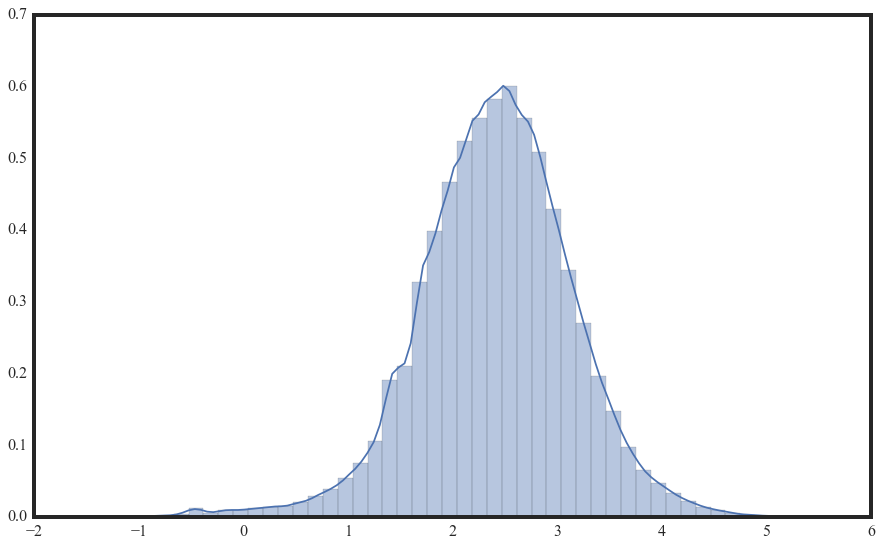

In [18]:
# Sanity Check
xy = dataUS.groupby('advertiserId')['cost'].sum().values
sns.distplot(np.log10(xy))
print np.median(xy),np.mean(xy)

In [19]:
#pick only important columns
data_clean = dataUS[['advertiserId','week', 'week_rank', 'spendAgeWeek_c', 'cost', 'employeeCount', 'isAdAgency',
                 'industry', 'type', 'source', 'salesTouched']]

In [20]:
#sanity_check : should have the same rows
print data_clean.shape, dataUS.shape

(2256794, 11) (2256794, 33)


In [21]:
# Sanity Check: Advertiser are not label twice
advertisers = data_clean.groupby(['advertiserId']).count()
advertisers_with_info = data_clean.groupby(['advertiserId', 'employeeCount', 'isAdAgency', 'industry',
                                            'type', 'source', 'salesTouched']).count() 
print 'Total advertisers:', advertisers.shape
print 'Total advertisers with labels:', advertisers_with_info.shape

Total advertisers: (224734, 10)
Total advertisers with labels: (224734, 4)


In [22]:
data_clean['first_four_weeks'] = data_clean['spendAgeWeek_c'].apply(lambda y: 1.0 if y<4 else 0.)

/Users/gmsardane/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
data_clean['cost_first_four_weeks'] = data_clean['first_four_weeks']*data_clean['cost']

/Users/gmsardane/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [24]:
#sanity_check : should have the same rows
print data_clean.shape, dataUS.shape

(2256794, 13) (2256794, 33)


In [25]:
#Aggregate data
agg_data = data_clean.groupby(['advertiserId', 'employeeCount', 'isAdAgency', 'industry',
                                            'type', 'source', 'salesTouched']).sum() 

In [26]:
agg_data.reset_index(inplace=True)

In [27]:
agg_data = agg_data[['advertiserId', 'employeeCount', 'isAdAgency', 'industry',
                                            'type', 'source', 'salesTouched', 'cost', 'cost_first_four_weeks']]

In [28]:
agg_data.head()

,advertiserId,employeeCount,isAdAgency,industry,type,source,salesTouched,cost,cost_first_four_weeks
0,2505904,1,0,Other,Direct Employer,organic,1,24.56,24.56
1,2505922,0,0,Hospitality/Travel,Direct Employer,others,0,442.49,92.28
2,2505985,1,0,Spam,Direct Employer,others,1,200.32,187.42
3,2506047,1,0,Blank,none,organic,0,11.31,11.31
4,2506048,1,0,Blank,Direct Employer,organic,0,320.82,115.98


In [29]:
cost_data = agg_data['cost'].values

270.065 1027.91784788
2.43146830388 2.41289335352
270.064999954 258.75774249
4259.62940729 4259.62940729


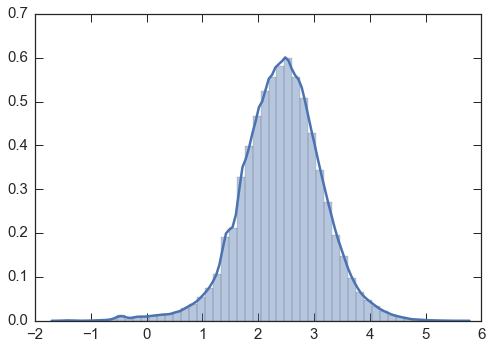

In [346]:
sns.distplot(np.log10(cost_data))
print np.median(cost_data),np.mean(cost_data)
print np.median(np.log10(cost_data)),np.mean(np.log10(cost_data))
print 10.**np.median(np.log10(cost_data)),10.**np.mean(np.log10(cost_data))

In [31]:
complete_data = dataUS[dataUS['spendAgeWeek_c']==73]

In [32]:
complete_data.shape

(1394, 33)

In [33]:
data_with_full_run = dataUS[dataUS['advertiserId'].isin(sorted(complete_data.advertiserId.unique()))]
data_with_full_run_early = data_with_full_run[data_with_full_run['spendAgeWeek_c']==0]

In [34]:
print sorted(data_with_full_run_early.week.unique())

['2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11']


In [35]:
advertiser_complete_cycle = sorted(complete_data.advertiserId.unique())

In [36]:
advertiser_incomplete_cycle = list(set(agg_data.advertiserId.unique()) - set(advertiser_complete_cycle))

In [37]:
print len(advertiser_complete_cycle), len(advertiser_incomplete_cycle)

1394 223340


### CLEAN DATA FINALLY!

In [143]:
test_data = agg_data[agg_data['advertiserId'].isin(advertiser_complete_cycle)]

In [276]:
to_be_predicted_data = agg_data[agg_data['advertiserId'].isin(advertiser_incomplete_cycle)]
to_be_predicted_data_google = to_be_predicted_data[to_be_predicted_data['source'] == 'google search']

In [277]:
print test_data.shape, to_be_predicted_data_google.shape
to_be_predicted_data.head()

(1394, 7) (5621, 9)


,advertiserId,employeeCount,isAdAgency,industry,type,source,salesTouched,cost,cost_first_four_weeks
0,2505904,1,0,Other,Direct Employer,organic,1,24.56,24.56
1,2505922,0,0,Hospitality/Travel,Direct Employer,others,0,442.49,92.28
2,2505985,1,0,Spam,Direct Employer,others,1,200.32,187.42
3,2506047,1,0,Blank,none,organic,0,11.31,11.31
4,2506048,1,0,Blank,Direct Employer,organic,0,320.82,115.98


### Important Cols
advertiserId
week
costmillicent

In [146]:
#Make dummies for categorical features.
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'GarageCond' => 'GarageCond_Ex', etc.
            col_data = pd.get_dummies(col_data, prefix = col)  
        if col == 'cost_first_four_weeks':
            col_data = col_data.replace(0, 1)
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

In [147]:
def remove_nans(df):
    nan_df = df[pd.isnull(df).any(axis=1)]
    for col in nan_df.columns:
        tmp = nan_df[col][pd.isnull(nan_df[col])]
        if len(tmp) >= 1:
            #print "These features have NULLs to signify the absence of such a feature:"
            print col, len(tmp)
            df[col] = df[col].fillna(1.)
    print np.shape(df)
    return df

In [148]:
## Define and remove repeat outliers
def remove_outliers(df):
    outliers  = []
    for feature in df.columns:
        
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(df[feature], 25)
        
        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(df[feature], 75)
        
        # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3-Q1)
        
        outliers = list(outliers + df[~((df[feature] >= Q1 - step) & \
                                                  (df[feature] <= Q3 + step))].index.tolist())
    
    # Select the indices for data points you wish to remove
    from collections import Counter
    counts = Counter(outliers)
    outliers = sorted([value for value, count in counts.items() if count > 2])
    return outliers

In [278]:
## Preprocess features with NaNs and Catgoricals
test_data = to_be_predicted_data_google.drop(['advertiserId', 'industry', 'source'], axis=1)
data_clean = remove_nans(test_data)
data_clean = preprocess_features(test_data)
print data_clean.shape
data_clean.head()

(5621, 6)
(5621, 9)


,employeeCount,isAdAgency,type_Direct Employer,type_Other,type_Staffing Agency,type_none,salesTouched,cost,cost_first_four_weeks
26,250,0,1.0,0.0,0.0,0.0,1,191.75,131.52
87,0,0,1.0,0.0,0.0,0.0,1,409.36,381.85
167,1,0,0.0,0.0,0.0,1.0,0,60.58,60.58
466,1,0,0.0,0.0,0.0,1.0,0,109.97,109.97
927,1,0,1.0,0.0,0.0,0.0,0,288.85,287.01


In [280]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

def create_sets(X, y):
    # Split into training and testing components first
    
    # Set the number of training points
    num_train = int(round(0.80*len(X)))
    
    # Set the number of testing points
    num_test = X.shape[0] - num_train
    
    # Shuffle and split the dataset into the number of training and testing points above
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = num_train, random_state=123458)
    
    # Show the results of the split
    print "Training set has {} samples.".format(X_train.shape[0])
    print "Testing set has {} samples.".format(X_test.shape[0])
    return X_train, X_test, y_train, y_test


In [281]:
def fit_model(X, y, n_estimators = 1000, min_samples_leaf = 1, min_samples_split =2):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20)
    regressor = GradientBoostingRegressor(loss= 'lad', n_estimators=n_estimators,min_samples_leaf = 1, 
                                          min_samples_split =2,random_state=102345)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'learning_rate': [0.01, 0.02, 0.05, 0.1], # 'n_estimators': [100, 500, 1000],
              'max_depth': [2, 3, 4, 5, 6], 'min_samples_leaf':  [2,3,5,7]}
    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)
    # Create the grid search object
    grid = GridSearchCV(regressor, params, cv=cv_sets, scoring = scoring_fnc)#, verbose=10)
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    # Print the optimal model after fitting the data
    print 'The cross-validation scores = {:.2f}'.format(grid.best_score_)
    print grid.best_estimator_
    return grid

In [299]:
to_be_predicted_data_google_clean = remove_nans(to_be_predicted_data_google)
to_be_predicted_data_google_clean = preprocess_features(to_be_predicted_data_google_clean)
to_be_predicted_data_google_clean_y = to_be_predicted_data_google_clean['cost']
to_be_predicted_data_google_clean_X = to_be_predicted_data_google_clean.drop(['cost'], axis=1)
to_be_predicted_data_google_clean_X.head()
#to_be_predicted_data_google_clean_X = to_be_predicted_data_google_clean.drop(['cost' ])

(5621, 9)


,advertiserId,employeeCount,isAdAgency,industry_Accounting/Consulting,industry_Advertising/Marketing,industry_Agriculture,industry_Arts/Entertainment/Recreation,industry_Automotive,industry_Beauty/Wellness,industry_Blank,...,industry_Technology/Information,industry_Telecom,industry_Transportation/Logistics,type_Direct Employer,type_Other,type_Staffing Agency,type_none,source_google search,salesTouched,cost_first_four_weeks
26,2507539,250,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,131.52
87,2508546,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,381.85
167,2512815,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,60.58
466,2516024,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,109.97
927,2524198,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,287.01


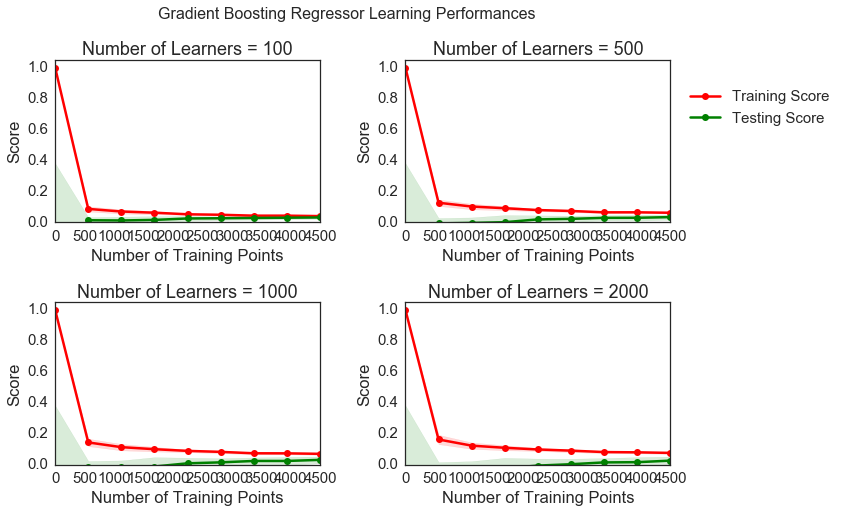

In [312]:
import visuals as vs
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")
vs.ModelLearning(to_be_predicted_data_clean_cluster.drop('cost_first_four_weeks', axis=1), to_be_predicted_data_clean_cluster.cost_first_four_weeks)


In [341]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(to_be_predicted_data_google_clean)
# Transform the good data using the PCA fit above
reduced_data = pca.transform(to_be_predicted_data_google_clean)

## Train-test split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.grid_search import GridSearchCV

from sklearn import linear_model
reg = linear_model.Lasso(alpha = 0.5)
X_train, X_test, y_train, y_test = create_sets(to_be_predicted_data_google_clean_X, 
                                               to_be_predicted_data_google_clean_y)
reg.fit(X_train, y_train)

Training set has 4497 samples.
Testing set has 1124 samples.


Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [342]:
pred = reg.predict(X_test)
print 'The R$^2$ = {:.2f}'.format(r2_score(pred, y_test))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred, y_test))
y_test.head()

The R$^2$ = 0.32
The  RMSE = 5.62e+05.


196229     125.85
177236      40.93
40822     1370.47
73034      365.46
113811    1497.97
Name: cost, dtype: float64

(array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.]),
 <a list of 6 Text yticklabel objects>)

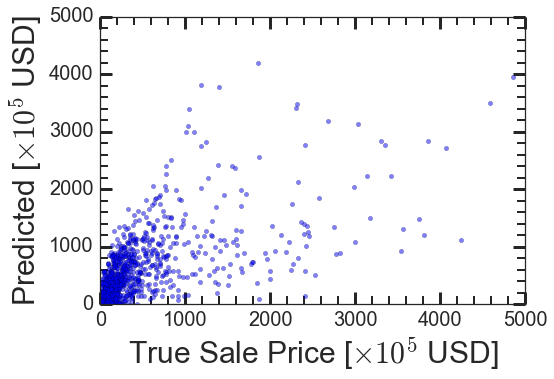

In [331]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.scatter(y_test, pred, alpha = 0.5)#, s = np.abs(y_test-pred)/y_test, color = 'red')
plt.xlabel(r"True Sale Price [$\times 10^{5} $ USD]", fontsize = 30);
plt.ylabel(r"Predicted [$\times 10^{5} $ USD]", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.plot(np.arange(0,10, 1), np.arange(0,10, 1), 'k--')
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(0,  0.5e4)
plt.ylim(0,  0.5e4)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig("FinalModel_linear_all.pdf")

In [ ]:
reg0.fea

In [131]:
## Preprocess features with NaNs and Catgoricals
tmp = to_be_predicted_data.drop(['advertiserId'], axis=1)
to_be_predicted_data_clean = remove_nans(tmp)
to_be_predicted_data_clean = preprocess_features(to_be_predicted_data_clean)
print to_be_predicted_data_clean.columns

(223340, 8)
Index([u'employeeCount', u'isAdAgency', u'industry_Accounting/Consulting',
       u'industry_Advertising/Marketing', u'industry_Agriculture',
       u'industry_Arts/Entertainment/Recreation', u'industry_Automotive',
       u'industry_Beauty/Wellness', u'industry_Blank',
       u'industry_Construction/Engineering', u'industry_Defense/Security',
       u'industry_Education', u'industry_Energy/Utilities',
       u'industry_Financial Services/Banking',
       u'industry_Food/Beverage Services', u'industry_Fraud/Scam',
       u'industry_Government/Military', u'industry_Health Care/Medical',
       u'industry_Hospitality/Travel', u'industry_Insurance',
       u'industry_Job Board (General)', u'industry_Job Seeker',
       u'industry_Legal', u'industry_Manufacturing',
       u'industry_Media/Newspaper', u'industry_Non-Profit/Association',
       u'industry_Other', u'industry_Real Estate',
       u'industry_Retail/Consumer Products', u'industry_Spam',
       u'industry_Staffing Fir

In [344]:
np.shape(reduced_data)

(5621, 2)

In [345]:
#to_be_predicted_data_clean_y = to_be_predicted_data_clean['cost']
#to_be_predicted_data_clean_X = to_be_predicted_data_clean[['cost_first_four_weeks', 'employeeCount']]
#np.shape(to_be_predicted_data_clean)
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

#data_clean_cluster = to_be_predicted_data[['cost_first_four_weeks', 'cost']].reset_index(drop=True)
to_be_predicted_data_clean_cluster = to_be_predicted_data_google_clean_X.drop('advertiserId', axis=1)#[['cost_first_four_weeks', 'cost']].reset_index(drop=True)
#sample = to_be_predicted_data_clean_cluster.sample(frac=0.01)
#data_clean_cluster['cost_first_four_weeks'] = np.log(data_clean_cluster['cost_first_four_weeks'])
#data_clean_cluster['cost'] = np.log(data_clean_cluster['cost'])
#X = StandardScaler().fit_transform(to_be_predicted_data_clean_cluster)
# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(to_be_predicted_data_clean_cluster, n_neighbors=10, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# create clustering estimators
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=2)
ward = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward',
                                           connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")

affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

affinity_propagation.fit(reduced_data)
centers = affinity_propagation.cluster_centers_

y_pred = affinity_propagation.predict(reduced_data)
center_colors = colors[:len(centers)]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors[y_pred].tolist(), s=20)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)

plt.xlim(-0.5, 5)
plt.ylim(-0.5, 5)
plt.xlabel('Cost First Four Weeks')
plt.ylabel('Cost ')
to_be_predicted_data_clean_cluster.head()

IndexError: index 560 is out of bounds for axis 1 with size 560

In [217]:
# TODO: Apply your clustering algorithm of choice to the reduced data 

from sklearn.mixture import GMM
for n in range(2, 11):
    clusterer = GMM(n_components = n, random_state=143)
    
    clusterer.fit(X)
    # Predict the cluster for each data point
    preds = clusterer.predict(X)
    
    # Find the cluster centers
    centers = clusterer.means_
    # Predict the cluster for each transformed sample data point
    # sample_preds = clusterer.predict(pca_samples)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    from sklearn.metrics import silhouette_score
    score = silhouette_score(X, preds)
    print "For {} clusters we get a silhouette coefficient of {:0.3f}".format(n, score)

For 2 clusters we get a silhouette coefficient of 0.657
For 3 clusters we get a silhouette coefficient of 0.641
For 4 clusters we get a silhouette coefficient of 0.493
For 5 clusters we get a silhouette coefficient of 0.361
For 6 clusters we get a silhouette coefficient of 0.362
For 7 clusters we get a silhouette coefficient of 0.359
For 8 clusters we get a silhouette coefficient of 0.368
For 9 clusters we get a silhouette coefficient of 0.363
For 10 clusters we get a silhouette coefficient of 0.367


In [203]:
clusterer = GMM(n_components = 2, random_state=143)
clusterer.fit(data_clean_cluster)
# Predict the cluster for each data point
preds = clusterer.predict(data_clean_cluster)

# Find the cluster centers
centers = clusterer.means_
centers

array([[  1013.17290629,  25754.40507001],
       [   164.54906296,   2874.49711245]])

In [208]:
def cluster_results(reduced_data, preds, centers):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)
    
	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = reduced_data.columns[0] , y = reduced_data.columns[1], \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

	# Plot transformed sample points 
	#ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
	#           s = 150, linewidth = 4, color = 'black', marker = 'x');

	# Set plot title
	ax.set_title("Cluster Learning on 1000-ish Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

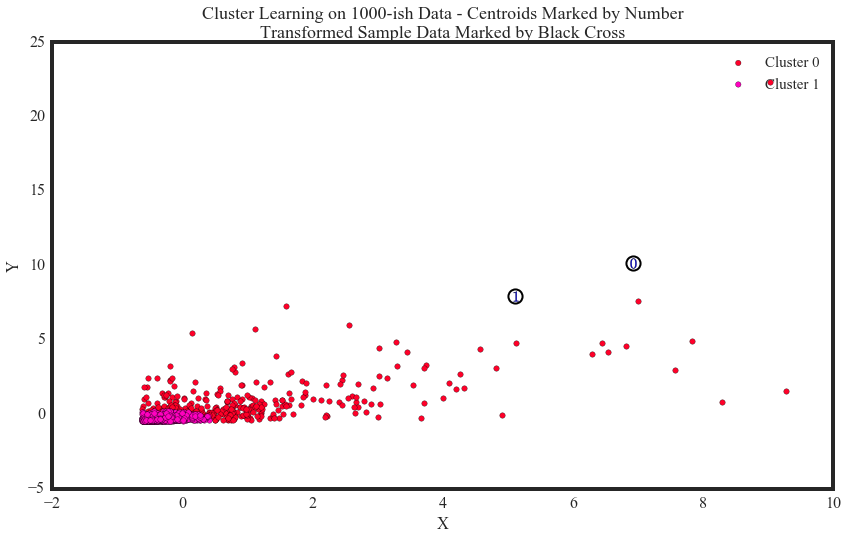

In [213]:
# Display the results of the clustering from implementation
import matplotlib.cm as cm
cluster_results(pd.DataFrame(X, columns=['X', 'Y']), preds, np.log(centers))


## Now I want to train these roughly 11,000 US data set that have data all throughout its lifetime. I want to predict the cost given all/any of the features.

In [ ]:
part_comp_data = complete_data[list(set(columns))]

In [ ]:
part_comp_data.head()

In [ ]:
data_clean = remove_nans(part_comp_data)
data_clean = preprocess_features(data_clean)
## Remove outliers
#outliers = remove_outliers(data)
#good_data = data_clean.drop(data_clean.index[outliers]).reset_index(drop = True)
#good_data_X = good_data.drop(['costmillicent'], axis =1)
#good_data_y =  good_data['costmillicent']
print "The dimensions of the data without outliers now is {}".format(np.shape(data_clean))
data_clean.columns

In [ ]:
len(complete_data)

In [ ]:
complete_data.columns

In [ ]:
set(complete_data.sales_touch)